In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv('./Drinks.csv')
df.head() 

,1,2,3,4,5,6,7,8,9,10,11,12,13,Class 1,Class 2,Class 3
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009,1,0,0
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242,1,0,0
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148,1,0,0
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574,1,0,0
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874,1,0,0


In [4]:
# Get the wine labels
y = df[['Class 1', 'Class 2', 'Class 3']].values

# Get inputs; we define our x and y here.
X = df[['1','2','3','4','5','6','7','8','9','10','11','12','13']].values

print(X.shape, y.shape) # Print shapes just to check


(178, 13) (178, 3)


In [7]:
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

In [48]:
def softmax(x):
    exps = np.exp(x) 
    return exps / np.sum(exps,axis=1,keepdims=True)

def softmax_grad(softmax):
    a = softmax.reshape(-1,1);
    return np.diagflat(a) - np.dot(a, a.T)


def softmax_loss(y,y_hat):
    minval = 0.0000001
    m = y.shape[0]
    loss = -1/m * np.sum(y * np.log(y_hat.clip(min=minval)))
    return loss

def tanh_derivative(x):
    return (1 - np.power(x, 2))


def loss_derivative(y,y_hat):
#     return (y_hat-y) * softmax_grad(softmax(y_hat))
# we need to compute softmax_derivative too and multiply to loss_derivative function.
    return (y_hat - y)


def feed_forward(model,a0):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'],model['b3']    
    z1 = a0.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    a2 = np.tanh(z2)
    z3 = a2.dot(W3) + b3
    a3 = softmax(z3)
    params = {'a0':a0,'z1':z1,'a1':a1,'z2':z2,'a2':a2,'a3':a3,'z3':z3}
    return params


def backward_prop(model,params,y):

    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'],model['W3'],model['b3']
    a0,a1,a2,a3 = params['a0'],params['a1'],params['a2'],params['a3']
    m = y.shape[0]
    
    #loss derivative with respect to output
    dz3 = loss_derivative(y=y,y_hat=a3)

    #loss derivative with respect to layer 2 weights
    dW3 = 1/m*(a2.T).dot(dz3) 

    # loss derivative with respect to 2 layer bias
    db3 = 1/m*np.sum(dz3, axis=0)
    
    #loss derivative with respect to layer 1
    dz2 = np.multiply(dz3.dot(W3.T) ,tanh_derivative(a2))
    
    # Calculate loss derivative with respect to layer 1 weights
    dW2 = 1/m*np.dot(a1.T, dz2)
    
    # Calculate loss derivative with respect to layer 1  bias
    db2 = 1/m*np.sum(dz2, axis=0)
    
    dz1 = np.multiply(dz2.dot(W2.T),tanh_derivative(a1))
    
    dW1 = 1/m*np.dot(a0.T,dz1)
    
    db1 = 1/m*np.sum(dz1,axis=0)
    
    grads = {'dW3':dW3, 'db3':db3, 'dW2':dW2,'db2':db2,'dW1':dW1,'db1':db1}
    return grads


def initialize_parameters(input_dim,hidden_dim,output_dim):
    
    W1 = 2 *np.random.randn(input_dim, hidden_dim) - 1
    
    b1 = np.zeros((1, hidden_dim))
    
    W2 = 2 * np.random.randn(hidden_dim, hidden_dim) - 1
    
    b2 = np.zeros((1, hidden_dim))
    W3 = 2 * np.random.rand(hidden_dim, output_dim) - 1
    b3 = np.zeros((1,output_dim))
    
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2,'W3':W3,'b3':b3}
    return model


def predict(model, x):
    c = feed_forward(model,x)
    y_hat = np.argmax(c['a3'], axis=1)
    return y_hat


def calc_accuracy(model,x,y):
    m = y.shape[0]
    pred = predict(model,x)
    pred = pred.reshape(y.shape)
    error = np.sum(np.abs(pred-y))
    return (m - error)/m * 100
losses = []



def train(model,X_,y_,learning_rate, epochs=20000):
    for i in range(0, epochs):
        params = feed_forward(model,X_)        
        grads = backward_prop(model,params,y_)
        W1, b1, W2, b2,b3,W3 = model['W1'], model['b1'], model['W2'], model['b2'],model['b3'],model["W3"]
       
        W1 -= learning_rate * grads['dW1']
        b1 -= learning_rate * grads['db1']
        W2 -= learning_rate * grads['dW2']
        b2 -= learning_rate * grads['db2']
        W3 -= learning_rate * grads['dW3']
        b3 -= learning_rate * grads['db3']

        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3':W3,'b3':b3}
        a3 = params['a3']
        print('Loss in iteration',i,':',softmax_loss(y_,a3))
        y_hat = predict(model,X_)
        y_true = y_.argmax(axis=1)
        print('Accuracy in iteration',i,':',accuracy_score(y_pred=y_hat,y_true=y_true)*100,'%')
        losses.append(accuracy_score(y_pred=y_hat,y_true=y_true)*100)
    return model

Loss in iteration 0 : 1.4504813381979211
Accuracy in iteration 0 : 25.280898876404496 %
Loss in iteration 1 : 1.3848066834768182
Accuracy in iteration 1 : 26.40449438202247 %
Loss in iteration 2 : 1.3260266812954302
Accuracy in iteration 2 : 26.40449438202247 %
Loss in iteration 3 : 1.273418157219208
Accuracy in iteration 3 : 26.96629213483146 %
Loss in iteration 4 : 1.2263067146919435
Accuracy in iteration 4 : 27.52808988764045 %
Loss in iteration 5 : 1.1840710478981928
Accuracy in iteration 5 : 29.775280898876407 %
Loss in iteration 6 : 1.1461450432017364
Accuracy in iteration 6 : 30.89887640449438 %
Loss in iteration 7 : 1.112017905445678
Accuracy in iteration 7 : 44.38202247191011 %
Loss in iteration 8 : 1.0812326561780647
Accuracy in iteration 8 : 46.62921348314607 %
Loss in iteration 9 : 1.0533834016889774
Accuracy in iteration 9 : 51.12359550561798 %
Loss in iteration 10 : 1.0281117672282296
Accuracy in iteration 10 : 53.37078651685393 %
Loss in iteration 11 : 1.0051028523932495

Loss in iteration 105 : 0.5156690408490157
Accuracy in iteration 105 : 81.46067415730337 %
Loss in iteration 106 : 0.5138236638652977
Accuracy in iteration 106 : 81.46067415730337 %
Loss in iteration 107 : 0.5120180252775246
Accuracy in iteration 107 : 81.46067415730337 %
Loss in iteration 108 : 0.5102503247763267
Accuracy in iteration 108 : 81.46067415730337 %
Loss in iteration 109 : 0.5085185612398999
Accuracy in iteration 109 : 81.46067415730337 %
Loss in iteration 110 : 0.5068206512227375
Accuracy in iteration 110 : 81.46067415730337 %
Loss in iteration 111 : 0.5051545155452369
Accuracy in iteration 111 : 82.02247191011236 %
Loss in iteration 112 : 0.5035181378738427
Accuracy in iteration 112 : 82.02247191011236 %
Loss in iteration 113 : 0.5019096009667317
Accuracy in iteration 113 : 82.02247191011236 %
Loss in iteration 114 : 0.5003271063179524
Accuracy in iteration 114 : 82.02247191011236 %
Loss in iteration 115 : 0.4987689821343634
Accuracy in iteration 115 : 82.02247191011236 %

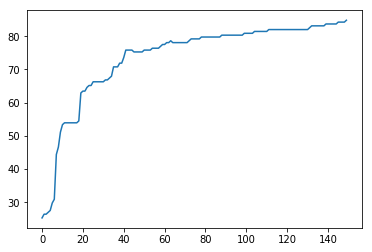

In [49]:

np.random.seed(0)
model = initialize_parameters(13,5,3)
model = train(model,X,y,learning_rate=0.07,epochs=150)
plt.plot(losses)